# COMP5318 Assignment 2: Image Classification

### Group number: 100, SID1: 490576560, SID2: 520653377 

## Setup and dependencies
All the required libraries/dependencies and the plotting environment are listed and set up here.

In [1]:
import time

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Make the notebook's output stable across runs.
# Random seed is set to 0 consistently.
np.random.seed(0)
tf.random.set_seed(0)
initializer = tf.keras.initializers.GlorotUniform(seed=0)
keras.backend.clear_session()

## 1. Data loading, preprocessing, and exploration
The documentation for the data loading function can be accessed [here](https://keras.io/api/datasets/fashion_mnist/).

### 1.1 Load data and declare variables

In [2]:
# Load the Fashion-MNIST dataset training and test sets as numpy arrays
(X_train_original, y_train_original), (X_test_original, y_test_original) = keras.datasets.fashion_mnist.load_data()
assert X_train_original.shape == (60000, 28, 28)
assert X_test_original.shape == (10000, 28, 28)
assert y_train_original.shape == (60000,)
assert y_test_original.shape == (10000,)

# An ordered list of the class names
class_names = ["T-shirt/top",
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle boot"
              ]

# Declare size of the image
IMAGE_SIZE = X_train_original[0].shape

### 1.2 Data processing

In [3]:
# Normalise data
X_train_full = X_train_original.reshape(X_train_original.shape[0], -1) # Flatten data from 3D to 2D
y_train_full = y_train_original.copy()
X_test = X_test_original.reshape(X_test_original.shape[0], -1) # Flatten data from 3D to 2D
y_test = y_test_original.copy()

scaler = MinMaxScaler()
scaler.fit(X_train_full)
X_train_full = scaler.transform(X_train_full) # apply normalisation to the training set
X_test = scaler.transform(X_test) # apply normalisation to the test set

X_train_full = X_train_full.reshape(X_train_original.shape[0], *IMAGE_SIZE) # restore the dimention from 2D to 3D
X_test = X_test.reshape(X_test_original.shape[0], *IMAGE_SIZE) # restore the dimention from 2D to 3D

# Create validation set from the training set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.9, stratify=y_train_full)

### 1.3 Data exploration

In [4]:
print(f"The original training set is {X_train_original.shape[0]} images with {X_train_original[0].shape} pixels, \
without normalization ({X_train_original.dtype}).")
print(f"The original test set is {X_test_original.shape[0]} images with {X_test_original[0].shape} pixels, \
without normalization ({X_test_original.dtype}).\n")

print(f"The size of training set is {X_train.shape[0]} ({X_train.dtype}), \
the size of validation set is {X_valid.shape[0]} ({X_valid.dtype}), and\
the size of test set is {X_test.shape[0]} ({X_test.dtype})")

The original training set is 60000 images with (28, 28) pixels, without normalization (uint8).
The original test set is 10000 images with (28, 28) pixels, without normalization (uint8).

The size of training set is 54000 (float64), the size of validation set is 6000 (float64), andthe size of test set is 10000 (float64)


In [5]:
def show_distribution(y):
    """Simple way to show a label distribution."""
    result = []
    for i in range(len(class_names)):
        result.append((y == i).sum())
    return result

print(f"There are {len(set(y_train_original))} different classes: {np.unique(y_train_original)}")
print(f"The label distribution of training set is {show_distribution(y_train)}")
print(f"The label distribution of validation set is {show_distribution(y_valid)}")
print(f"The label distribution of test set is {show_distribution(y_test)}")

There are 10 different classes: [0 1 2 3 4 5 6 7 8 9]
The label distribution of training set is [5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400, 5400]
The label distribution of validation set is [600, 600, 600, 600, 600, 600, 600, 600, 600, 600]
The label distribution of test set is [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


Some examples:


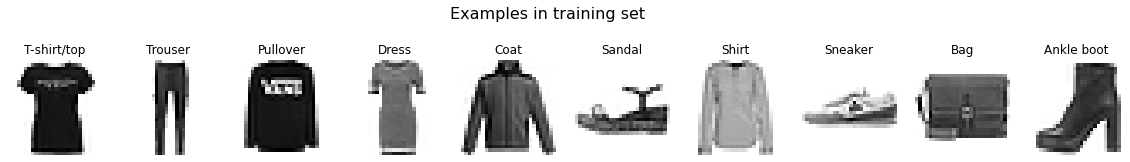

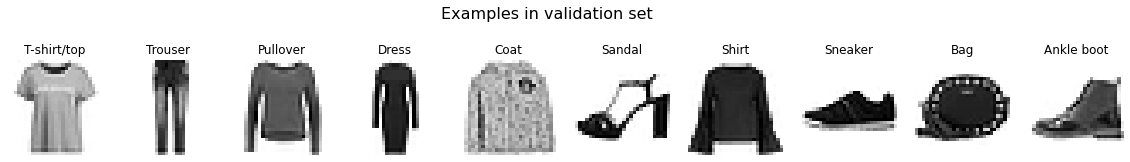

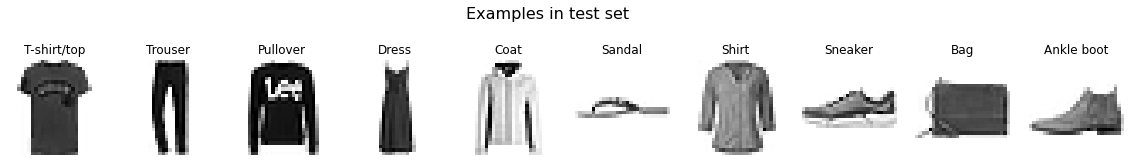

In [6]:
def plot_examples(X, y, title=""):
    """Plot a grid of images from different classes."""
    # Size figure depending on the size of the grid
    plt.figure(figsize=(20, 2))
    plt.suptitle(title, fontsize=16,x=0.5,y=1.2,)

    index = []
    # search index
    for i in range(len(class_names)):
        for j in range(len(y)):
            if i == y[j]:
                index.append(j)
                break

    # Plot the image at appropriate place in grid
    for i in range(len(index)):
        plt.subplot(1, len(index), i + 1)
        plt.imshow(X[index[i]], cmap="binary")
        plt.title(class_names[y[index[i]]])
        plt.axis('off')
            
    plt.show()

print("Some examples:")

plot_examples(X_train, y_train, "Examples in training set")
plot_examples(X_valid, y_valid, "Examples in validation set")
plot_examples(X_test, y_test, "Examples in test set")

## 2. Algorithm design and setup

### 2.1  K-nearest neighbors

First, A group of simple algorithms from the first 6 weeks are compared. They are: K-nearest neighbors, Naive Bayes, Decision tree, and Random forest. We simply train the model with default/simple parameters on the full training set, and test their accuracy.

In [7]:
neigh = KNeighborsClassifier(n_neighbors=10) # k shoule be less than sqrt(#training_examples), commercial packages typically use k=10

# Training and timer
time_stamp = time.time()
neigh.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
neigh_training_time = time.time() - time_stamp

In [8]:
nb = GaussianNB()

# Training and timer
time_stamp = time.time()
nb.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
nb_training_time = time.time() - time_stamp

In [9]:
# Running in arround 30s

tree = DecisionTreeClassifier(criterion='entropy', random_state=0) # without setting max_depth results in overfitting.

# Training and timer
time_stamp = time.time()
tree.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
tree_training_time = time.time() - time_stamp

In [10]:
# Running in arround 90s

rnd = RandomForestClassifier(criterion='entropy', random_state=0) # n_estimators=100 by default

# Training and timer
time_stamp = time.time()
rnd.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
rnd_training_time = time.time() - time_stamp

In [11]:
print(f"The accuracy of KNN is {neigh.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {neigh_training_time:.2f} s.")
print(f"The accuracy of NB is {nb.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {nb_training_time:.2f} s.")
print(f"The accuracy of DT is {tree.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {tree_training_time:.2f} s.")
print(f"The accuracy of RF is {rnd.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}, training time is {rnd_training_time:.2f} s.")

The accuracy of KNN is 0.8519, training time is 0.05 s.
The accuracy of NB is 0.5838, training time is 0.54 s.
The accuracy of DT is 0.8001, training time is 28.93 s.
The accuracy of RF is 0.8760, training time is 78.00 s.


Althouth Random Forest performs best, the training time is relatively long. Noticing that KNN is simple but with a content accuracy among them, the training time is  also tiny. Therefore, KNN is chosen.

### 2.2 Fully connected neural network

First, the numbers of layers need to be settled. Apart from the **input layer** and **output layer**, the numebr of hidden layer can be a variable. According to Cybenko(1998), any function (including discontinuous) can be approximated to arbitrary small error by a network with two hidden layers. To make the model small, we choose **two hidden layers**.

Number of neurons in the input layer: 784   
For numerical attributes, basically 1 neuron per attribute, in this dataset, we have 28 * 28 = 784 atttributes each example. Thus, the number of neurons of input layer should be 784. Simply, we just use **keras.layers.Flatten(input_shape)**

Number of neurons in the output layer: 10   
1 for each class. Therefore, the number of the output layers should be 10. The **softmax** function ($\frac{e^{z_{i}}}{\sum_{j=1}^{K} e^{z_{j}}}$) converts the raw outputs of this layer into a probability distribution over the classes. 

Now we choose the hidden layers.   
**Sigmoid** is the most widely used transfer function.
We simply set most paras by default as well as the basic **SGD** learning algorithm. Since our labels are in index form rather than encoded as one-hot vectors, as we discussed earlier, we utilise the **sparse_categorical_crossentropy** loss. Then we observe the trend of the numbers of neurons with respect to MSE.

In [12]:
def test_build_mlp(num1=50, num2=50):
    """Build the MLP model with the specified number of neurons."""
    # Set Random seed to 0
    initializer = tf.keras.initializers.GlorotUniform(seed=0)
    # Define a test MLP model
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=IMAGE_SIZE),
        keras.layers.Dense(num1, activation="sigmoid", kernel_initializer=initializer),
        keras.layers.Dense(num2, activation="sigmoid", kernel_initializer=initializer),
        keras.layers.Dense(len(class_names), activation="softmax", kernel_initializer=initializer)
    ])

    opt = keras.optimizers.SGD() # default learning_rate=0.01
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

    # model.summary()
    return model

def test_train_mlp(num1, num2, max_epochs=50, criterion=0.02):
    """Training the model.
    max_epochs: the maximum number of epochs to terminate.
    criterion: stop when the difference between the loss of the last 5 epoch is less than."""
    # Train the classifier.
    mlp = test_build_mlp(num1, num2)
    loss_list = []
    for i in range(max_epochs):
        history = mlp.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=1)
        loss_list.append(history.history["loss"][0])

        # Stop condition
        if len(loss_list) > 5 and loss_list[-6] - loss_list[-1] < criterion:
            print(len(loss_list))
            break
    
    return loss_list[-1], len(loss_list)

In [13]:
# Running in arround 960s

# some possible numbers to choose
hidden_layer_1 = [100, 200, 300, 400, 500, 600]

# results
loss_history_1 = []
epoch_history_1 = []

# for the first hidden layer
for i in hidden_layer_1:
    loss, epoch = test_train_mlp(i, 50)
    loss_history_1.append(loss)
    epoch_history_1.append(epoch)

1688/1688 [==============================] - 2s 1ms/step - loss: 0.4257 - accuracy: 0.8496 - val_loss: 0.4290 - val_accuracy: 0.8463
31
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4294 - accuracy: 0.8491 - val_loss: 0.4309 - val_accuracy: 0.8438
30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4352 - accuracy: 0.8459 - val_loss: 0.4363 - val_accuracy: 0.8408
29
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4377 - accuracy: 0.8448 - val_loss: 0.4387 - val_accuracy: 0.8400
28
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4376 - accuracy: 0.8454 - val_loss: 0.4379 - val_accuracy: 0.8400
28
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4369 - accuracy: 0.8463 - val_loss: 0.4386 - val_accuracy: 0.8400
28


In [14]:
loss_history_1 = [round(i, 4) for i in loss_history_1]
print(f"The min loss is {min(loss_history_1)} when neurons is equal to {hidden_layer_1[loss_history_1.index(min(loss_history_1))]}")

print(f"Loss history: {loss_history_1}")
print(f"Epoch history: {epoch_history_1}")

The min loss is 0.4257 when neurons is equal to 100
Loss history: [0.4257, 0.4294, 0.4352, 0.4377, 0.4376, 0.4369]
Epoch history: [31, 30, 29, 28, 28, 28]


It shows that when the number of neurons of the first layer is 100, the loss is minimal. Although the epochs is slightly larger, which may enhance the performance, the training time is much faster because of the lesser neurons. To keep the model small, we choose the 100 as the first number of neurons of the hidden layers.

In [15]:
# Running in arround 340s

# some possible numbers to choose
hidden_layer_2 = [20, 40, 60, 80]

# results
loss_history_2 = []
epoch_history_2 = []

# for the first hidden layer
for i in hidden_layer_2:
    loss, epoch = test_train_mlp(100, i)
    loss_history_2.append(loss)
    epoch_history_2.append(epoch)

1688/1688 [==============================] - 2s 1ms/step - loss: 0.4352 - accuracy: 0.8483 - val_loss: 0.4389 - val_accuracy: 0.8427
34
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4277 - accuracy: 0.8493 - val_loss: 0.4320 - val_accuracy: 0.8438
31
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4220 - accuracy: 0.8510 - val_loss: 0.4235 - val_accuracy: 0.8455
31
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4261 - accuracy: 0.8487 - val_loss: 0.4294 - val_accuracy: 0.8420
31


In [16]:
loss_history_2 = [round(i, 4) for i in loss_history_2]
print(f"The min loss is {min(loss_history_2)} when neurons is equal to {hidden_layer_2[loss_history_2.index(min(loss_history_2))]}")

print(f"Loss history: {loss_history_2}")
print(f"Epoch history: {epoch_history_2}")

The min loss is 0.422 when neurons is equal to 60
Loss history: [0.4352, 0.4277, 0.422, 0.4261]
Epoch history: [34, 31, 31, 31]


We select 60 as the neurons of the second hidden layer, as it achieves the best result with a less epochs, and the training time is similar.

### 2.3 Convolutional neural network

The architecture of CNN is settled in this section.   

The input shape shoule be (28, 28, 1). This last dimension indicates the channel. The dataset consists of grey images, thus, the channel is 1. Although usually the CNN performs well, the theory of determining the architecture, such as the number of convolutional layers, the number of filters, is unclear. Sometimes it is determined by experiment and experience. Given that the condition is limited, we just choose the similar architecture from the tutorial. In other words, we choose two conv and pool blocks with 32, 64 (empirically it should be exponentiation of 2) filters respectively, follower by a simple FC layer.   

We also choose Max Pooling due to the distribution of pixels each image (features are presented as large value of pixels).   

We have discussed the ReLU and Softmax previously.

The drouout layer is added to avoid overfitting.

The rest paras such as filter size, strides, and learning rate, will be tuned in section 3.3.

In [17]:
keras.Sequential([
    # Specify the input shape
    keras.Input(shape=(*IMAGE_SIZE, 1)),
    
    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", strides=(1, 1), kernel_initializer=initializer),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'), # padding evenly
    
    # Conv and pool block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", strides=(1, 1), kernel_initializer=initializer),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'), # padding evenly
    
    # Flatten and classify using dense output layer
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax", kernel_initializer=initializer),
])

## 3. Hyperparameter tuning

In [18]:
# Helper method in this section.
def get_result(estimator, paras, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, epochs=1):
    """get grid search result.
    estimator: model to be tuned.
    paras: an instance of ParameterGrid."""
    # Return a dict
    result = {
        "best_paras": None,
        "best_score": 0,
        "best_estimator": None,
        "results": [],
    }

    i = 0

    # Grid search for each combination.
    for para in paras:
        # Set para
        current_estimator = clone(estimator)
        current_estimator.set_params(**para)

        # Training and timer
        t1 = time.time()
        if epochs == 1:
            current_estimator.fit(X_train, y_train)
        else:
            current_estimator.fit(X_train, y_train, epochs=epochs)
        t2 = time.time()

        # Score on validation set
        score = current_estimator.score(X_valid, y_valid)
        t3 = time.time()

        # result for each combination
        temp = {}
        temp["paras"] = para
        temp["training_time"] = t2 - t1
        temp["validation_time"] = t3 - t2
        temp["score"] =score
        
        # Update the best result
        result["results"].append(temp)
        if score > result["best_score"]:
            result["best_paras"] = para
            result["best_score"] = score
            result["best_estimator"] = current_estimator
        
        i += 1
        print(f"{i} out of {len(list(paras))} finished: {para}")

    return result

def show_results(name, result, X_test=X_test, y_test=y_test):
    """Show the results."""
    print(f"Results for {name}:")
    print("Best parameters: {}".format(result["best_paras"]))
    print("Best validation score: {:.4f}".format(result["best_score"]))
    print("Test set score: {:.4f}".format(result["best_estimator"].score(X_test, y_test)))

    # table of results
    df = pd.DataFrame(
        columns=["Score", "training_time", "validation_time"], 
        index=[str(result["results"][i]["paras"]) for i in range(len(result["results"]))]
        )

    for i in range(len(result["results"])):
        df.loc[str(result["results"][i]["paras"])] = [
            round(result["results"][i]["score"], 4),
            round(result["results"][i]["training_time"], 2),
            round(result["results"][i]["validation_time"], 2)
            ]

    df.to_csv(f'{name}_results.csv')
    display(df)

### 3.1 K-nearest neighbors

First, to determine a rough trend of the accuracy with different k, we calculate an accuracy every 10 with different k, until k = 245 (sqrt(#examples)), e.g., k = [1, 11, 21, ..., 241]

In [19]:
# Running in arroung 190s

k_value = [1 + i for i in range(245)]
k_acc = []

for i in k_value:
    if i % 10 != 1:
        continue
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
    k_acc.append(knn.score(X_test.reshape(X_test.shape[0], -1), y_test))
    print(f"k = {i}\t finished.")

k = 1	 finished.
k = 11	 finished.
k = 21	 finished.
k = 31	 finished.
k = 41	 finished.
k = 51	 finished.
k = 61	 finished.
k = 71	 finished.
k = 81	 finished.
k = 91	 finished.
k = 101	 finished.
k = 111	 finished.
k = 121	 finished.
k = 131	 finished.
k = 141	 finished.
k = 151	 finished.
k = 161	 finished.
k = 171	 finished.
k = 181	 finished.
k = 191	 finished.
k = 201	 finished.
k = 211	 finished.
k = 221	 finished.
k = 231	 finished.
k = 241	 finished.


<Figure size 144x144 with 0 Axes>

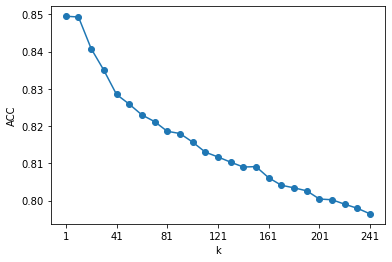

In [20]:
plt.figure(figsize=(2, 2))
fig, ax = plt.subplots()

ax.plot([i*10 + 1 for i in range(25)], k_acc, marker="o")
ax.set(xlabel="k", ylabel="ACC", xticks=range(1, 250, 40))
plt.show()

From the figure, the trend is roughly decending. Therefore, we can choose a range of k in [1, 21]

In [21]:
# Running in arroung 140s

k_value = [i for i in range(1,21)]
k_acc = []

for i in k_value:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
    k_acc.append(knn.score(X_test.reshape(X_test.shape[0], -1), y_test))
    print(f"k = {i}\t finished.")

k = 1	 finished.
k = 2	 finished.
k = 3	 finished.
k = 4	 finished.
k = 5	 finished.
k = 6	 finished.
k = 7	 finished.
k = 8	 finished.
k = 9	 finished.
k = 10	 finished.
k = 11	 finished.
k = 12	 finished.
k = 13	 finished.
k = 14	 finished.
k = 15	 finished.
k = 16	 finished.
k = 17	 finished.
k = 18	 finished.
k = 19	 finished.
k = 20	 finished.


<Figure size 144x144 with 0 Axes>

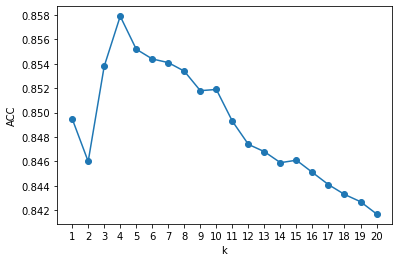

In [22]:
plt.figure(figsize=(2, 2))
fig, ax = plt.subplots()

ax.plot(k_value, k_acc, marker="o")
ax.set(xlabel="k", ylabel="ACC", xticks=k_value)
plt.show()

From the figure above, we chose k = [3, 5, 9]. For p, we chose p [1, 2], it represents manhattan_distance and euclidean_distance respectively. We also consider the weight (uniform, distance) each point contribute to.

If we use CV with 10 folds, totally we need 3 * 2 * 2 * cv = 120 on 90% training set. Considering the running time, we use standard grid search instead.

In [23]:
# Setting parameters
param_grid = {
    'n_neighbors': [3, 5, 9],
    'p': [1, 2],
    "weights": ["uniform", "distance"],
    }

knn_paras = ParameterGrid(param_grid)

print(f"There are {len(list(knn_paras))} combinations.")
print("Parameter grid:\n{}".format(param_grid))

# ----------------------------------------------------------
# CV for tuning
# Setting the 10 fold stratified cross-validation

# cvKFold=StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
# grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cvKFold, return_train_score=True, verbose=3)
# grid_search.fit(X_train_full.reshape(60000, -1), y_train_full)

There are 12 combinations.
Parameter grid:
{'n_neighbors': [3, 5, 9], 'p': [1, 2], 'weights': ['uniform', 'distance']}


In [24]:
# Running in around 410s

# Tuning KNN paras, 12 combination in total.
knn_result = get_result(
    KNeighborsClassifier(), 
    knn_paras, 
    X_train=X_train.reshape(X_train.shape[0], -1), 
    X_valid=X_valid.reshape(X_valid.shape[0], -1)
    )

1 out of 12 finished: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
2 out of 12 finished: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
3 out of 12 finished: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
4 out of 12 finished: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
5 out of 12 finished: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
6 out of 12 finished: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
7 out of 12 finished: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
8 out of 12 finished: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
9 out of 12 finished: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
10 out of 12 finished: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
11 out of 12 finished: {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
12 out of 12 finished: {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}


In [25]:
# Running in around 110s

show_results("KNN", knn_result, X_test=X_test.reshape(X_test.shape[0], -1))

Results for KNN:
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best validation score: 0.8653
Test set score: 0.8567


,Score,training_time,validation_time
"{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}",0.8622,0.05,40.38
"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}",0.8653,0.05,40.33
"{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}",0.8583,0.05,2.81
"{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}",0.8602,0.04,2.68
"{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}",0.8603,0.05,40.39
"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}",0.8622,0.04,40.23
"{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.855,0.05,2.92
"{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.8577,0.05,2.68
"{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}",0.8628,0.05,40.42
"{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}",0.8645,0.04,40.57


### 3.2 Fully connected neural network

From section 2.2, we settled the numbers of neurons (100, 20) in hidden layers. Although the number of hidden layers as well as number of neurons are also hyperparameter, to avoid a great running time due to a number of combination of paras, we design the structure first and tune the other paras in this section.

In [26]:
def build_mlp(activation_function="relu"):
    """Build a Keras MLP for 10 class classification with desired parameters."""
    
    model = keras.models.Sequential()
    
    # Add the input layer
    model.add(keras.layers.Flatten(input_shape=IMAGE_SIZE))
    
    # Add the hidden layers with activation function
    model.add(keras.layers.Dense(100, activation=activation_function, kernel_initializer=initializer))
    model.add(keras.layers.Dense(60, activation=activation_function, kernel_initializer=initializer))
        
    # Add the output layer for 10 class classification
    model.add(keras.layers.Dense(10, activation="softmax", kernel_initializer=initializer))
    
    return model

# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them
keras_classifier = KerasClassifier(build_mlp,
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   optimizer__lr=0.01,
                                   metrics=["accuracy"]
                                  )

param_grid = {
    "optimizer__lr": [0.1, 0.01, 0.001],
    "activation_function": ["relu", "sigmoid", "tanh", None],
    "optimizer": ["sgd", "Adam"],
}

mlp_paras = ParameterGrid(param_grid)

print(f"There are {len(list(mlp_paras))} combinations.")
print("Parameter grid:\n{}".format(param_grid))

There are 24 combinations.
Parameter grid:
{'optimizer__lr': [0.1, 0.01, 0.001], 'activation_function': ['relu', 'sigmoid', 'tanh', None], 'optimizer': ['sgd', 'Adam']}


In [27]:
# Running in arround 1800s

mlp_result = get_result(keras_classifier, mlp_paras, epochs=30)

Epoch 1/30


c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 974us/step - loss: 0.5523 - accuracy: 0.8009
Epoch 2/30
1688/1688 [==============================] - 2s 965us/step - loss: 0.4040 - accuracy: 0.8533
Epoch 3/30
1688/1688 [==============================] - 2s 968us/step - loss: 0.3632 - accuracy: 0.8651
Epoch 4/30
1688/1688 [==============================] - 2s 963us/step - loss: 0.3385 - accuracy: 0.8740
Epoch 5/30
1688/1688 [==============================] - 2s 967us/step - loss: 0.3194 - accuracy: 0.8820
Epoch 6/30
1688/1688 [==============================] - 2s 955us/step - loss: 0.3053 - accuracy: 0.8870
Epoch 7/30
1688/1688 [==============================] - 2s 953us/step - loss: 0.2929 - accuracy: 0.8906
Epoch 8/30
1688/1688 [==============================] - 2s 975us/step - loss: 0.2823 - accuracy: 0.8937
Epoch 9/30
1688/1688 [==============================] - 2s 954us/step - loss: 0.2732 - accuracy: 0.8967
Epoch 10/30
1688/1688 [==============================] - 2s 949us/step - lo

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 960us/step - loss: 0.7777 - accuracy: 0.7462
Epoch 2/30
1688/1688 [==============================] - 2s 983us/step - loss: 0.5046 - accuracy: 0.8268
Epoch 3/30
1688/1688 [==============================] - 2s 961us/step - loss: 0.4568 - accuracy: 0.8404
Epoch 4/30
1688/1688 [==============================] - 2s 956us/step - loss: 0.4297 - accuracy: 0.8486
Epoch 5/30
1688/1688 [==============================] - 2s 959us/step - loss: 0.4100 - accuracy: 0.8567
Epoch 6/30
1688/1688 [==============================] - 2s 962us/step - loss: 0.3938 - accuracy: 0.8626
Epoch 7/30
1688/1688 [==============================] - 2s 957us/step - loss: 0.3807 - accuracy: 0.8661
Epoch 8/30
1688/1688 [==============================] - 2s 958us/step - loss: 0.3701 - accuracy: 0.8691
Epoch 9/30
1688/1688 [==============================] - 2s 972us/step - loss: 0.3599 - accuracy: 0.8726
Epoch 10/30
1688/1688 [==============================] - 2s 957us/step - lo

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 953us/step - loss: 1.6533 - accuracy: 0.5011
Epoch 2/30
1688/1688 [==============================] - 2s 957us/step - loss: 0.9808 - accuracy: 0.6989
Epoch 3/30
1688/1688 [==============================] - 2s 963us/step - loss: 0.7788 - accuracy: 0.7530
Epoch 4/30
1688/1688 [==============================] - 2s 970us/step - loss: 0.6913 - accuracy: 0.7784
Epoch 5/30
1688/1688 [==============================] - 2s 961us/step - loss: 0.6389 - accuracy: 0.7931
Epoch 6/30
1688/1688 [==============================] - 2s 951us/step - loss: 0.6022 - accuracy: 0.8038
Epoch 7/30
1688/1688 [==============================] - 2s 950us/step - loss: 0.5752 - accuracy: 0.8100
Epoch 8/30
1688/1688 [==============================] - 2s 985us/step - loss: 0.5540 - accuracy: 0.8154
Epoch 9/30
1688/1688 [==============================] - 2s 961us/step - loss: 0.5372 - accuracy: 0.8201
Epoch 10/30
1688/1688 [==============================] - 2s 952us/step - lo

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 1.9412 - accuracy: 0.2261
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.9550 - accuracy: 0.1905
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.9386 - accuracy: 0.1932
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.0199 - accuracy: 0.1769
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.8893 - accuracy: 0.1932
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.8357 - accuracy: 0.1922
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.8877 - accuracy: 0.1916
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.8569 - accuracy: 0.1944
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.7971 - accuracy: 0.1955
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.7549 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5480 - accuracy: 0.8045
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4461 - accuracy: 0.8405
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4232 - accuracy: 0.8490
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4166 - accuracy: 0.8520
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4067 - accuracy: 0.8541
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3957 - accuracy: 0.8585
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3893 - accuracy: 0.8604
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3806 - accuracy: 0.8635
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3764 - accuracy: 0.8653
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3885 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5115 - accuracy: 0.8196
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3767 - accuracy: 0.8640
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3391 - accuracy: 0.8759
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3171 - accuracy: 0.8829
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2985 - accuracy: 0.8889
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2863 - accuracy: 0.8931
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2728 - accuracy: 0.8998
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2595 - accuracy: 0.9026
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2523 - accuracy: 0.9046
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2444 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.9854 - accuracy: 0.6590
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5370 - accuracy: 0.8100
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4667 - accuracy: 0.8337
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4331 - accuracy: 0.8441
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4111 - accuracy: 0.8536
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3940 - accuracy: 0.8597
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3807 - accuracy: 0.8630
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3702 - accuracy: 0.8664
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3603 - accuracy: 0.8699
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3519 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 2.0653 - accuracy: 0.4333
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4501 - accuracy: 0.6122
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.1183 - accuracy: 0.6688
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.9311 - accuracy: 0.6953
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.8186 - accuracy: 0.7176
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7447 - accuracy: 0.7360
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6929 - accuracy: 0.7507
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6548 - accuracy: 0.7615
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6253 - accuracy: 0.7721
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6012 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 994us/step - loss: 2.3311 - accuracy: 0.1289
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.2469 - accuracy: 0.3896
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.2102 - accuracy: 0.4634
Epoch 4/30
1688/1688 [==============================] - 2s 994us/step - loss: 2.1686 - accuracy: 0.5458
Epoch 5/30
1688/1688 [==============================] - 2s 990us/step - loss: 2.1194 - accuracy: 0.5681
Epoch 6/30
1688/1688 [==============================] - 2s 993us/step - loss: 2.0606 - accuracy: 0.6006
Epoch 7/30
1688/1688 [==============================] - 2s 997us/step - loss: 1.9917 - accuracy: 0.6125
Epoch 8/30
1688/1688 [==============================] - 2s 994us/step - loss: 1.9150 - accuracy: 0.6008
Epoch 9/30
1688/1688 [==============================] - 2s 992us/step - loss: 1.8350 - accuracy: 0.6037
Epoch 10/30
1688/1688 [==============================] - 2s 996us/step - loss: 

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 1.6611 - accuracy: 0.2850
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.6164 - accuracy: 0.2919
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.5782 - accuracy: 0.2944
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.5460 - accuracy: 0.3080
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.5494 - accuracy: 0.3295
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.6137 - accuracy: 0.3158
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.5360 - accuracy: 0.3406
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.7608 - accuracy: 0.2815
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.1013 - accuracy: 0.1883
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.0346 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5692 - accuracy: 0.7917
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4766 - accuracy: 0.8277
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4439 - accuracy: 0.8389
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4365 - accuracy: 0.8410
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4318 - accuracy: 0.8442
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4265 - accuracy: 0.8456
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4108 - accuracy: 0.8529
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4088 - accuracy: 0.8534
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4006 - accuracy: 0.8553
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3939 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.6677 - accuracy: 0.7802
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4039 - accuracy: 0.8548
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3615 - accuracy: 0.8694
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3375 - accuracy: 0.8782
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3197 - accuracy: 0.8845
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3047 - accuracy: 0.8879
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2923 - accuracy: 0.8935
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2793 - accuracy: 0.8969
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2704 - accuracy: 0.9001
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2610 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 976us/step - loss: 0.5242 - accuracy: 0.8104
Epoch 2/30
1688/1688 [==============================] - 2s 983us/step - loss: 0.4022 - accuracy: 0.8542
Epoch 3/30
1688/1688 [==============================] - 2s 976us/step - loss: 0.3634 - accuracy: 0.8670
Epoch 4/30
1688/1688 [==============================] - 2s 984us/step - loss: 0.3389 - accuracy: 0.8759
Epoch 5/30
1688/1688 [==============================] - 2s 981us/step - loss: 0.3202 - accuracy: 0.8826
Epoch 6/30
1688/1688 [==============================] - 2s 985us/step - loss: 0.3045 - accuracy: 0.8871
Epoch 7/30
1688/1688 [==============================] - 2s 989us/step - loss: 0.2912 - accuracy: 0.8921
Epoch 8/30
1688/1688 [==============================] - 2s 972us/step - loss: 0.2820 - accuracy: 0.8958
Epoch 9/30
1688/1688 [==============================] - 2s 964us/step - loss: 0.2721 - accuracy: 0.8979
Epoch 10/30
1688/1688 [==============================] - 2s 979us/step - lo

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 983us/step - loss: 0.7262 - accuracy: 0.7684
Epoch 2/30
1688/1688 [==============================] - 2s 985us/step - loss: 0.4912 - accuracy: 0.8301
Epoch 3/30
1688/1688 [==============================] - 2s 982us/step - loss: 0.4465 - accuracy: 0.8421
Epoch 4/30
1688/1688 [==============================] - 2s 986us/step - loss: 0.4212 - accuracy: 0.8510
Epoch 5/30
1688/1688 [==============================] - 2s 986us/step - loss: 0.4032 - accuracy: 0.8583
Epoch 6/30
1688/1688 [==============================] - 2s 985us/step - loss: 0.3888 - accuracy: 0.8631
Epoch 7/30
1688/1688 [==============================] - 2s 985us/step - loss: 0.3774 - accuracy: 0.8667
Epoch 8/30
1688/1688 [==============================] - 2s 981us/step - loss: 0.3676 - accuracy: 0.8690
Epoch 9/30
1688/1688 [==============================] - 2s 985us/step - loss: 0.3593 - accuracy: 0.8717
Epoch 10/30
1688/1688 [==============================] - 2s 984us/step - lo

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 973us/step - loss: 1.3950 - accuracy: 0.6037
Epoch 2/30
1688/1688 [==============================] - 2s 974us/step - loss: 0.8948 - accuracy: 0.7302
Epoch 3/30
1688/1688 [==============================] - 2s 970us/step - loss: 0.7577 - accuracy: 0.7646
Epoch 4/30
1688/1688 [==============================] - 2s 976us/step - loss: 0.6848 - accuracy: 0.7839
Epoch 5/30
1688/1688 [==============================] - 2s 990us/step - loss: 0.6372 - accuracy: 0.7955
Epoch 6/30
1688/1688 [==============================] - 2s 975us/step - loss: 0.6028 - accuracy: 0.8040
Epoch 7/30
1688/1688 [==============================] - 2s 981us/step - loss: 0.5769 - accuracy: 0.8100
Epoch 8/30
1688/1688 [==============================] - 2s 977us/step - loss: 0.5562 - accuracy: 0.8153
Epoch 9/30
1688/1688 [==============================] - 2s 976us/step - loss: 0.5394 - accuracy: 0.8190
Epoch 10/30
1688/1688 [==============================] - 2s 985us/step - lo

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 2.8471 - accuracy: 0.1004
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.8309 - accuracy: 0.1002
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.8583 - accuracy: 0.1000
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.8601 - accuracy: 0.0985
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.8354 - accuracy: 0.1016
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.8326 - accuracy: 0.1012
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.8048 - accuracy: 0.1018
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.8371 - accuracy: 0.0993
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.8450 - accuracy: 0.1003
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 2.8541 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.6807 - accuracy: 0.7537
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6639 - accuracy: 0.7633
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6622 - accuracy: 0.7596
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6841 - accuracy: 0.7497
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6846 - accuracy: 0.7524
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6729 - accuracy: 0.7712
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7334 - accuracy: 0.7183
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6781 - accuracy: 0.7455
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6698 - accuracy: 0.7530
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6718 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.4843 - accuracy: 0.8262
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3712 - accuracy: 0.8659
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3352 - accuracy: 0.8773
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3142 - accuracy: 0.8840
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2957 - accuracy: 0.8907
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2834 - accuracy: 0.8943
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2723 - accuracy: 0.8994
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2596 - accuracy: 0.9034
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2502 - accuracy: 0.9055
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2447 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.6285 - accuracy: 0.7890
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4883 - accuracy: 0.8287
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4665 - accuracy: 0.8383
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4565 - accuracy: 0.8393
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4475 - accuracy: 0.8433
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4412 - accuracy: 0.8469
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4356 - accuracy: 0.8478
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4341 - accuracy: 0.8479
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4287 - accuracy: 0.8503
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4274 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.6610 - accuracy: 0.7794
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4938 - accuracy: 0.8293
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4627 - accuracy: 0.8385
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4478 - accuracy: 0.8437
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4373 - accuracy: 0.8485
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4296 - accuracy: 0.8525
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4238 - accuracy: 0.8530
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4195 - accuracy: 0.8547
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4151 - accuracy: 0.8555
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4121 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 1.1842 - accuracy: 0.6423
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7551 - accuracy: 0.7579
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6598 - accuracy: 0.7864
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6095 - accuracy: 0.7996
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5773 - accuracy: 0.8082
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5540 - accuracy: 0.8153
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5369 - accuracy: 0.8185
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5231 - accuracy: 0.8222
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5120 - accuracy: 0.8264
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5030 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 11.5627 - accuracy: 0.7412
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1019.8622 - accuracy: 0.7256
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 32.1146 - accuracy: 0.7461
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 15.4382 - accuracy: 0.7470
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 914.6314 - accuracy: 0.7195
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 52.7696 - accuracy: 0.7643
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 28.1203 - accuracy: 0.7514
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 833.8857 - accuracy: 0.7334
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 52.6891 - accuracy: 0.7636
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 38.

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.7356 - accuracy: 0.7692
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.8600 - accuracy: 0.7878
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5032 - accuracy: 0.8278
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5822 - accuracy: 0.8106
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6317 - accuracy: 0.8097
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.5931 - accuracy: 0.8140
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4842 - accuracy: 0.8362
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5471 - accuracy: 0.8221
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5862 - accuracy: 0.8167
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 1.0495 - accurac

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 2s 1ms/step - loss: 0.5494 - accuracy: 0.8081
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4708 - accuracy: 0.8358
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4517 - accuracy: 0.8435
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4407 - accuracy: 0.8465
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4332 - accuracy: 0.8486
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4258 - accuracy: 0.8503
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4213 - accuracy: 0.8515
Epoch 8/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4145 - accuracy: 0.8552
Epoch 9/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4121 - accuracy: 0.8542
Epoch 10/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4123 - accurac

In [28]:
show_results("MLP", mlp_result)

Results for MLP:
Best parameters: {'activation_function': 'sigmoid', 'optimizer': 'Adam', 'optimizer__lr': 0.001}
Best validation score: 0.8940
313/313 [==============================] - 0s 791us/step
Test set score: 0.8886


,Score,training_time,validation_time
"{'activation_function': 'relu', 'optimizer': 'sgd', 'optimizer__lr': 0.1}",0.872,49.03,0.31
"{'activation_function': 'relu', 'optimizer': 'sgd', 'optimizer__lr': 0.01}",0.8833,49.13,0.25
"{'activation_function': 'relu', 'optimizer': 'sgd', 'optimizer__lr': 0.001}",0.8488,48.98,0.25
"{'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.1}",0.198,52.16,0.25
"{'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.01}",0.8577,52.98,0.26
"{'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.001}",0.8927,52.72,0.25
"{'activation_function': 'sigmoid', 'optimizer': 'sgd', 'optimizer__lr': 0.1}",0.8867,51.64,0.25
"{'activation_function': 'sigmoid', 'optimizer': 'sgd', 'optimizer__lr': 0.01}",0.8455,51.55,0.26
"{'activation_function': 'sigmoid', 'optimizer': 'sgd', 'optimizer__lr': 0.001}",0.6782,51.52,0.26
"{'activation_function': 'sigmoid', 'optimizer': 'Adam', 'optimizer__lr': 0.1}",0.4063,54.35,0.26


From the table above, both {'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.001} and {'activation_function': 'sigmoid', 'optimizer': 'Adam', 'optimizer__lr': 0.001} are good. Considering the limitations of Sigmoid activation function, we choose **ReLU** in this study.

Then we observe the trend of epochs with these paras.

In [29]:
# build a model with paras we just chose
mlp_model = build_mlp(activation_function="relu")

mlp_model.summary()

mlp_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_35 (Flatten)        (None, 784)               0         
                                                                 
 dense_103 (Dense)           (None, 100)               78500     
                                                                 
 dense_104 (Dense)           (None, 60)                6060      
                                                                 
 dense_105 (Dense)           (None, 10)                610       
                                                                 
Total params: 85,170
Trainable params: 85,170
Non-trainable params: 0
_________________________________________________________________


In [30]:
mlp_history = mlp_model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5115 - accuracy: 0.8196 - val_loss: 0.3997 - val_accuracy: 0.8535
Epoch 2/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3767 - accuracy: 0.8640 - val_loss: 0.3651 - val_accuracy: 0.8670
Epoch 3/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3391 - accuracy: 0.8759 - val_loss: 0.3397 - val_accuracy: 0.8723
Epoch 4/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3171 - accuracy: 0.8829 - val_loss: 0.3278 - val_accuracy: 0.8783
Epoch 5/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2985 - accuracy: 0.8889 - val_loss: 0.3359 - val_accuracy: 0.8768
Epoch 6/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2863 - accuracy: 0.8931 - val_loss: 0.3239 - val_accuracy: 0.8792
Epoch 7/30
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2728 - accuracy: 0.8998 - val_loss: 0.3243 - val_accuracy:

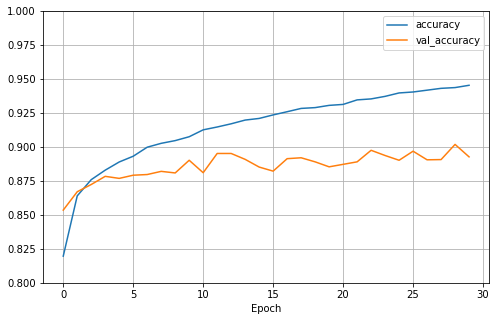

In [31]:
# Convert the history dictionary to a Pandas dataframe and extract the accuracies
accuracies = pd.DataFrame(mlp_history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

The accuracy of validation set fluctuated since epoch = 10, thus, we set the epochs = 10 to keep it small.

### 3.3 Convolutional neural network

In section 2.2, we fixed a set ot paras as well as the architecture of CNN.

In [32]:
def build_cnn(kernel_size=(3, 3), strides=(1, 1), activation_function="relu"):
    """Build a Keras CNN for 10 class classification with desired parameters."""
    
    model = keras.Sequential([
        # Specify the input shape
        keras.Input(shape=(*IMAGE_SIZE, 1)),
        
        # Conv and pool block 1
        keras.layers.Conv2D(
            32, 
            kernel_size=kernel_size, 
            activation=activation_function, 
            strides=strides,
            kernel_initializer=initializer
            ),
        keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'), # padding evenly
        
        # Conv and pool block 2
        keras.layers.Conv2D(
            64, 
            kernel_size=kernel_size, 
            activation=activation_function, 
            strides=strides,
            kernel_initializer=initializer
            ),
        keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'), # padding evenly
        
        # Flatten and classify using dense output layer
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(len(class_names), activation="softmax", kernel_initializer=initializer),
    ])
    
    return model

# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_cnn if we wish to tune them
keras_classifier = KerasClassifier(build_cnn,
                                   kernel_size=(3, 3),
                                   strides=(1, 1),
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="adam",
                                   optimizer__lr=0.01,
                                   metrics=["accuracy"]
                                  )

# For an odd-sized filter, all the previous layer pixels would be symmetrical around the output pixel.
param_grid = {
    "optimizer__lr": [0.01, 0.005, 0.001],
    "kernel_size": [(3, 3), (5, 5)],
    "strides": [(1, 1), (2, 2)]
}

cnn_paras = ParameterGrid(param_grid)

print(f"There are {len(list(cnn_paras))} combinations.")
print("Parameter grid:\n{}".format(param_grid))

There are 12 combinations.
Parameter grid:
{'optimizer__lr': [0.01, 0.005, 0.001], 'kernel_size': [(3, 3), (5, 5)], 'strides': [(1, 1), (2, 2)]}


In [33]:
# Running in arround 1100s

cnn_result = get_result(
    keras_classifier, 
    cnn_paras,
    X_train=np.expand_dims(X_train, -1),
    X_valid=np.expand_dims(X_valid, -1), 
    epochs=10
    )

Epoch 1/10


c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 14s 8ms/step - loss: 0.5044 - accuracy: 0.8175
Epoch 2/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4250 - accuracy: 0.8472
Epoch 3/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4157 - accuracy: 0.8500
Epoch 4/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4070 - accuracy: 0.8526
Epoch 5/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4085 - accuracy: 0.8510
Epoch 6/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4048 - accuracy: 0.8523
Epoch 7/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4004 - accuracy: 0.8531
Epoch 8/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3999 - accuracy: 0.8557
Epoch 9/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3996 - accuracy: 0.8537
Epoch 10/10
188/188 [==============================] - 0s 2ms/step
1 out of 12 finis

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 5s 3ms/step - loss: 0.6453 - accuracy: 0.7617
Epoch 2/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.5320 - accuracy: 0.8065
Epoch 3/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.5166 - accuracy: 0.8136
Epoch 4/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.5010 - accuracy: 0.8199
Epoch 5/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4991 - accuracy: 0.8179
Epoch 6/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4936 - accuracy: 0.8190
Epoch 7/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4884 - accuracy: 0.8219
Epoch 8/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4878 - accuracy: 0.8227
Epoch 9/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4846 - accuracy: 0.8223
Epoch 10/10
188/188 [==============================] - 0s 998us/step
2 out of 12 finished: {'

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 13s 8ms/step - loss: 0.4701 - accuracy: 0.8295
Epoch 2/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3734 - accuracy: 0.8655
Epoch 3/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3519 - accuracy: 0.8721
Epoch 4/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3374 - accuracy: 0.8782
Epoch 5/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3284 - accuracy: 0.8799
Epoch 6/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3258 - accuracy: 0.8808
Epoch 7/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3199 - accuracy: 0.8826
Epoch 8/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3155 - accuracy: 0.8835
Epoch 9/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3061 - accuracy: 0.8873
Epoch 10/10
188/188 [==============================] - 0s 2ms/step
3 out of 12 finis

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 5s 3ms/step - loss: 0.6295 - accuracy: 0.7703
Epoch 2/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4755 - accuracy: 0.8267
Epoch 3/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4458 - accuracy: 0.8371
Epoch 4/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4258 - accuracy: 0.8459
Epoch 5/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4152 - accuracy: 0.8508
Epoch 6/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4043 - accuracy: 0.8530
Epoch 7/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3981 - accuracy: 0.8532
Epoch 8/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3947 - accuracy: 0.8547
Epoch 9/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3920 - accuracy: 0.8544
Epoch 10/10
188/188 [==============================] - 0s 1ms/step
4 out of 12 finished: {'ke

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 13s 8ms/step - loss: 0.5201 - accuracy: 0.8115
Epoch 2/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3668 - accuracy: 0.8700
Epoch 3/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.3272 - accuracy: 0.8831
Epoch 4/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3026 - accuracy: 0.8908
Epoch 5/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2882 - accuracy: 0.8964
Epoch 6/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.2735 - accuracy: 0.9010
Epoch 7/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2611 - accuracy: 0.9049
Epoch 8/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2527 - accuracy: 0.9085
Epoch 9/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2463 - accuracy: 0.9091
Epoch 10/10
188/188 [==============================] - 1s 2ms/step
5 out of 12 finis

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 5s 3ms/step - loss: 0.7486 - accuracy: 0.7271
Epoch 2/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5156 - accuracy: 0.8138
Epoch 3/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4618 - accuracy: 0.8321
Epoch 4/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4325 - accuracy: 0.8451
Epoch 5/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4119 - accuracy: 0.8521
Epoch 6/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3971 - accuracy: 0.8567
Epoch 7/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3840 - accuracy: 0.8605
Epoch 8/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3750 - accuracy: 0.8638
Epoch 9/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3660 - accuracy: 0.8673
Epoch 10/10
188/188 [==============================] - 0s 992us/step
6 out of 12 finished: {'

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 14s 8ms/step - loss: 0.5870 - accuracy: 0.7874
Epoch 2/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4884 - accuracy: 0.8250
Epoch 3/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4843 - accuracy: 0.8254
Epoch 4/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4742 - accuracy: 0.8286
Epoch 5/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4735 - accuracy: 0.8298
Epoch 6/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4656 - accuracy: 0.8309
Epoch 7/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4777 - accuracy: 0.8279
Epoch 8/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.4648 - accuracy: 0.8329
Epoch 9/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4661 - accuracy: 0.8282
Epoch 10/10
188/188 [==============================] - 1s 3ms/step
7 out of 12 finis

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 5s 3ms/step - loss: 0.6395 - accuracy: 0.7672
Epoch 2/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5430 - accuracy: 0.8005
Epoch 3/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.5268 - accuracy: 0.8028
Epoch 4/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.5178 - accuracy: 0.8073
Epoch 5/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.5118 - accuracy: 0.8103
Epoch 6/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.5085 - accuracy: 0.8110
Epoch 7/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.5047 - accuracy: 0.8121
Epoch 8/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5016 - accuracy: 0.8131
Epoch 9/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4968 - accuracy: 0.8129
Epoch 10/10
188/188 [==============================] - 0s 1ms/step
8 out of 12 finished: {'ke

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 15s 9ms/step - loss: 0.5323 - accuracy: 0.8076
Epoch 2/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.4223 - accuracy: 0.8460
Epoch 3/10
1688/1688 [==============================] - 15s 9ms/step - loss: 0.3962 - accuracy: 0.8539
Epoch 4/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3853 - accuracy: 0.8608
Epoch 5/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3756 - accuracy: 0.8621
Epoch 6/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3715 - accuracy: 0.8636
Epoch 7/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3687 - accuracy: 0.8651
Epoch 8/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3588 - accuracy: 0.8683
Epoch 9/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3582 - accuracy: 0.8688
Epoch 10/10
188/188 [==============================] - 1s 3ms/step
9 out of 12 finis

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 5s 3ms/step - loss: 0.6417 - accuracy: 0.7657
Epoch 2/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4959 - accuracy: 0.8187
Epoch 3/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4638 - accuracy: 0.8282
Epoch 4/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4484 - accuracy: 0.8337
Epoch 5/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4397 - accuracy: 0.8359
Epoch 6/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4279 - accuracy: 0.8392
Epoch 7/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4168 - accuracy: 0.8424
Epoch 8/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4161 - accuracy: 0.8434
Epoch 9/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4096 - accuracy: 0.8454
Epoch 10/10
188/188 [==============================] - 0s 1ms/step
10 out of 12 finished: {'k

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 15s 9ms/step - loss: 0.5577 - accuracy: 0.7958
Epoch 2/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3883 - accuracy: 0.8614
Epoch 3/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3465 - accuracy: 0.8748
Epoch 4/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3230 - accuracy: 0.8843
Epoch 5/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3048 - accuracy: 0.8896
Epoch 6/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2918 - accuracy: 0.8934
Epoch 7/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2797 - accuracy: 0.8995
Epoch 8/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2705 - accuracy: 0.9016
Epoch 9/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2617 - accuracy: 0.9042
Epoch 10/10
188/188 [==============================] - 1s 3ms/step
11 out of 12 fini

c:\Program Files\Anaconda3-2021.11x64\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1688/1688 [==============================] - 5s 3ms/step - loss: 0.7298 - accuracy: 0.7438
Epoch 2/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.5274 - accuracy: 0.8151
Epoch 3/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4729 - accuracy: 0.8302
Epoch 4/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4409 - accuracy: 0.8399
Epoch 5/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4174 - accuracy: 0.8481
Epoch 6/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4015 - accuracy: 0.8536
Epoch 7/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3896 - accuracy: 0.8577
Epoch 8/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3779 - accuracy: 0.8606
Epoch 9/10
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3678 - accuracy: 0.8639
Epoch 10/10
188/188 [==============================] - 0s 997us/step
12 out of 12 finished: {

In [34]:
show_results("CNN", cnn_result, X_test=np.expand_dims(X_test, -1))

Results for CNN:
Best parameters: {'kernel_size': (3, 3), 'optimizer__lr': 0.001, 'strides': (1, 1)}
Best validation score: 0.9175
313/313 [==============================] - 1s 2ms/step
Test set score: 0.9125


,Score,training_time,validation_time
"{'kernel_size': (3, 3), 'optimizer__lr': 0.01, 'strides': (1, 1)}",0.8717,130.88,0.54
"{'kernel_size': (3, 3), 'optimizer__lr': 0.01, 'strides': (2, 2)}",0.8602,43.34,0.31
"{'kernel_size': (3, 3), 'optimizer__lr': 0.005, 'strides': (1, 1)}",0.8988,130.16,0.54
"{'kernel_size': (3, 3), 'optimizer__lr': 0.005, 'strides': (2, 2)}",0.889,42.69,0.31
"{'kernel_size': (3, 3), 'optimizer__lr': 0.001, 'strides': (1, 1)}",0.9175,138.12,0.6
"{'kernel_size': (3, 3), 'optimizer__lr': 0.001, 'strides': (2, 2)}",0.889,45.52,0.31
"{'kernel_size': (5, 5), 'optimizer__lr': 0.01, 'strides': (1, 1)}",0.8502,136.82,0.61
"{'kernel_size': (5, 5), 'optimizer__lr': 0.01, 'strides': (2, 2)}",0.8483,44.92,0.32
"{'kernel_size': (5, 5), 'optimizer__lr': 0.005, 'strides': (1, 1)}",0.8833,141.77,0.61
"{'kernel_size': (5, 5), 'optimizer__lr': 0.005, 'strides': (2, 2)}",0.8688,43.64,0.32


From the table above, the best paras in our setting is: 'kernel_size': (3, 3), 'optimizer__lr': 0.001, 'strides': (1, 1)   

Then we observe the trend of epochs with these paras.

In [35]:
# build a model with paras we just chose
cnn_model = build_cnn(
    kernel_size=(3, 3),
    strides=(1, 1),
    activation_function="relu"
    )

cnn_model.summary()

cnn_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_48 (Flatten)        (None, 2304)              0         
                                                                 
 dropout_13 (Dropout)        (None, 2304)            

In [36]:
cnn_history = cnn_model.fit(
    np.expand_dims(X_train, -1),
    y_train, 
    epochs=30, 
    validation_data=(np.expand_dims(X_valid, -1), y_valid)
    )

Epoch 1/30
1688/1688 [==============================] - 14s 8ms/step - loss: 0.5201 - accuracy: 0.8115 - val_loss: 0.3583 - val_accuracy: 0.8712
Epoch 2/30
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3668 - accuracy: 0.8700 - val_loss: 0.3091 - val_accuracy: 0.8873
Epoch 3/30
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3272 - accuracy: 0.8831 - val_loss: 0.2851 - val_accuracy: 0.8962
Epoch 4/30
1688/1688 [==============================] - 14s 8ms/step - loss: 0.3026 - accuracy: 0.8908 - val_loss: 0.2628 - val_accuracy: 0.9043
Epoch 5/30
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2882 - accuracy: 0.8964 - val_loss: 0.2507 - val_accuracy: 0.9078
Epoch 6/30
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2735 - accuracy: 0.9010 - val_loss: 0.2696 - val_accuracy: 0.8988
Epoch 7/30
1688/1688 [==============================] - 14s 8ms/step - loss: 0.2611 - accuracy: 0.9049 - val_loss: 0.2415 - val_ac

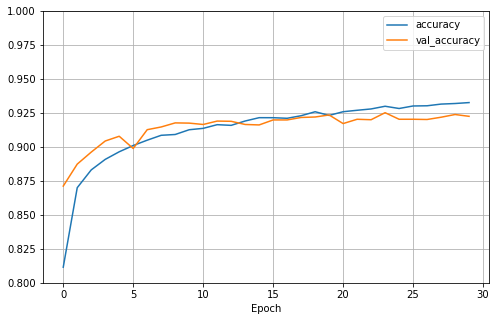

In [37]:
# Convert the history dictionary to a Pandas dataframe and extract the accuracies
accuracies = pd.DataFrame(cnn_history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

The accuracy of validation set fluctuated since epoch = 12, thus, we set the epochs = 12.

## 4. Final models

### 4.1 K-nearest neighbors

Best paras for K-nearest neighbors is:  
'n_neighbors'= 3, 'p'= 1, 'weights'= 'distance'.

In [38]:
# Set the best paras
knn_best_paras = dict({'n_neighbors': 3, 'p': 1, 'weights': 'distance'})

knn = KNeighborsClassifier(**knn_best_paras)
knn_runtime = time.time()
knn.fit(X_train_full.reshape(X_train_full.shape[0], -1), y_train_full)
knn_runtime = time.time() - knn_runtime

In [39]:
# Running in around 120s

# Performance on test set.
print(f"KNN training time: {knn_runtime:.2f} s")
print(f"KNN score on the test set: {knn.score(X_test.reshape(X_test.shape[0], -1), y_test):.4f}")

KNN training time: 0.07 s
KNN score on the test set: 0.8597


### 4.2 Fully connected neural network

We settled the size of layers (784, 100, 60, 10) in section 2.2; and settled the the best paras of our experimental settings:   
'activation_function': 'relu', 'optimizer': 'Adam', 'optimizer__lr': 0.001   
epochs: 10

In [40]:
# Running in around 25s

keras.backend.clear_session()

# Set Random seed to 0
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# Build the final model
mlp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=IMAGE_SIZE),
    keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    keras.layers.Dense(60, activation="relu", kernel_initializer=initializer),
    keras.layers.Dense(10, activation="softmax", kernel_initializer=initializer)
])

mlp.summary()

# Complie the model
mlp.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model
mlp_runtime = time.time()
mlp.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=1)
mlp_runtime = time.time() - mlp_runtime

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 60)                6060      
                                                                 
 dense_2 (Dense)             (None, 10)                610       
                                                                 
Total params: 85,170
Trainable params: 85,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5115 - accuracy: 0.8196 - val_loss: 0.3997 - val_accuracy: 0.8535
Epoch 2/10
1688/1688 [==================

In [41]:
# Performance on test set.
loss, accuracy = mlp.evaluate(X_test, y_test)
print(f"MLP training time: {mlp_runtime:.2f} s")
print(f"MLP score on the test set: {accuracy:.4f}")


313/313 [==============================] - 0s 971us/step - loss: 0.3335 - accuracy: 0.8864
MLP training time: 24.62 s
MLP score on the test set: 0.8864


### 4.3 Convolutional neural network

We designed a proper architecture of CNN in section 2.3; and settled the the best paras of our experimental settings:   
'kernel_size': (3, 3), 'optimizer__lr': 0.001, 'strides': (1, 1)  
epochs: 12

In [42]:
# Running in around 200s

keras.backend.clear_session()

# Set Random seed to 0
initializer = tf.keras.initializers.GlorotUniform(seed=0)

# Build the final model
cnn = keras.Sequential([
        # Specify the input shape
        keras.Input(shape=(*IMAGE_SIZE, 1)),
        
        # Conv and pool block 1
        keras.layers.Conv2D(
            32, 
            kernel_size=(3, 3), 
            activation="relu", 
            strides=(1, 1),
            kernel_initializer=initializer
            ),
        keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'), # padding evenly
        
        # Conv and pool block 2
        keras.layers.Conv2D(
            64, 
            kernel_size=(3, 3), 
            activation="relu", 
            strides=(1, 1),
            kernel_initializer=initializer
            ),
        keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'), # padding evenly
        
        # Flatten and classify using dense output layer
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(len(class_names), activation="softmax", kernel_initializer=initializer),
    ])

cnn.summary()

# Complie the model
cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model
cnn_runtime = time.time()
cnn.fit(np.expand_dims(X_train, -1), y_train, epochs=12, validation_data=(np.expand_dims(X_valid, -1), y_valid), verbose=1)
cnn_runtime = time.time() - cnn_runtime

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0

In [43]:
# Performance on test set.
loss, accuracy = cnn.evaluate(np.expand_dims(X_test, -1), y_test)
print(f"CNN training time: {cnn_runtime:.2f} s")
print(f"CNN score on the test set: {accuracy:.4f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.2414 - accuracy: 0.9126
CNN training time: 191.29 s
CNN score on the test set: 0.9126


Finalized at 10/12 1:30